### Import Useful Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import ast
import torch
import os
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, f1_score ,classification_report
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from google.colab import drive

start_time = time.time()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Retrieve Dataset

In [2]:
max = 20
path = '/content/drive/MyDrive/Satori Assignment/data/preprocessed_data_'+ str(max) +'.csv'
df = pd.read_csv(path)
df['Target'] = df['Target'].apply(ast.literal_eval)
df['Tag'] = df['Tag'].apply(ast.literal_eval)

print(df.shape)
display(df.head())

(33374, 5)


,Text,Tag,Num_Tags,Num_Words,Target
0,mysql error php mysql query mysql error php my...,"[mysql, php]",2,138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
1,setup site-wide variables php setup site-wide ...,[php],1,51,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,select select select way select data one multi...,[mysql],1,31,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,comes comes comes searched little gotten parti...,[c],1,46,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,code ask yes/no question javascript code ask y...,[javascript],1,26,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


> We load the preprocessed_data_K CSV file, which stores data after preprocessing with the Top K Tag Combinations.

In [3]:
unique_tags = set([tag for sublist in df['Tag'] for tag in sublist])

print(f"Number of Unique Tags: {len(unique_tags)}")
print(unique_tags)

Number of Unique Tags: 16
{'c#', 'mysql', 'javascript', 'html', 'c', 'android', 'sql', 'git', 'python', 'angularjs', 'php', 'c++', 'java', 'css', 'r', 'jquery'}


### Split data

#### Convert Multilabel to Single-Label (for Split Purposes)

In [4]:
def calculate_tag_combinations(temp_df):
    """
    Create a dataframe 'tag_combination', which stores the unique combination of Tags and the number of appearance
    """

    if temp_df.empty:
        print('Error: Provided DataFrame is empty!')
        return

    temp_df['Tag'] = temp_df['Tag'].apply(sorted)
    temp_df['Tag_Tuple'] = temp_df['Tag'].apply(tuple)
    tag_combinations = temp_df.groupby('Tag_Tuple').size().reset_index(name='Count')
    temp_df.drop(columns=['Tag_Tuple'], inplace=True)
    tag_combinations = tag_combinations.sort_values(by='Count', ascending=False)

    sum_count = tag_combinations['Count'].sum()
    all_tags = [tag for tag_tuple in tag_combinations['Tag_Tuple'] for tag in tag_tuple]
    num_unique_tags = len(set(all_tags))

    print(f"Number of Questions of Tag Combinations: {sum_count}")
    print(f"Number of unique tags of Tag Combinations: {num_unique_tags}")
    print(f"Minimum Frequency of Tag Combinations: {tag_combinations['Count'].iloc[-1]}\n")
    display(tag_combinations)

    return tag_combinations

original_tag_combinations = calculate_tag_combinations(df)

Number of Questions of Tag Combinations: 33374
Number of unique tags of Tag Combinations: 16
Minimum Frequency of Tag Combinations: 823



,Tag_Tuple,Count
0,"(android,)",3630
12,"(javascript, jquery)",2700
10,"(java,)",2519
11,"(javascript,)",2501
17,"(php,)",2190
18,"(python,)",2109
4,"(c#,)",1944
13,"(jquery,)",1898
6,"(css, html)",1879
5,"(c++,)",1608


> Display in a proper way the distribution of Tag Combinations. This will be helpful so as to reassure in a given dataframe data are well distributed and randomly picken. This is a way to convert multilabel problem to single class problem and manually split the data on Tag Combinations and not on each single Tag.

In [5]:
def split_data(tag_combinations, df, create_val=True, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Shuffle the dataframe
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    val_ratio = val_ratio if create_val else 0

    # Dicts to store counts for each combination
    train_counts = {combination: 0 for combination in tag_combinations['Tag_Tuple']}
    val_counts = {combination: 0 for combination in tag_combinations['Tag_Tuple']}
    test_counts = {combination: 0 for combination in tag_combinations['Tag_Tuple']}

    # Appropriate ratio of tag combinations for each set
    for index, row in tag_combinations.iterrows():
        combination = row['Tag_Tuple']
        count = row['Count']

        train_counts[combination] += int(count*train_ratio)
        val_counts[combination] += int(count*val_ratio)
        test_counts[combination] += count - int(count*train_ratio) - int(count*val_ratio)

    # Store data to list for each set
    train_data, val_data, test_data = [], [], []

    # Iterate over rows in df and assign to train, val, or test sets
    for index, row in df_shuffled.iterrows():
        combination = row['Tag']
        if train_counts[tuple(combination)] > 0:
            train_data.append(row)
            train_counts[tuple(combination)] -= 1
        elif test_counts[tuple(combination)] > 0:
            test_data.append(row)
            test_counts[tuple(combination)] -= 1
        elif val_counts[tuple(combination)] > 0:
            val_data.append(row)
            val_counts[tuple(combination)] -= 1

    assert len(train_data) + len(val_data) + len(test_data) == len(df), "Total number of examples in train, val, and test sets does not match the total number of examples in the original dataframe"
    return pd.DataFrame(train_data), pd.DataFrame(val_data), pd.DataFrame(test_data)

train_df, val_df, test_df = split_data(original_tag_combinations, df)

> Now with this generic function we utilise a logic with dicts in order to track the number of times of each Tag Combination and finally retrieve with a modifiable ratio train, val and test sets.

#### Train, Val and Test Dataframes

In [6]:
train_df

,Text,Tag,Num_Tags,Num_Words,Target
0,echo php html line echo php html line echo php...,[php],1,37,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,aligning list links right aligning list links ...,"[css, html]",2,150,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,sort unordered list inside anchor tag sort uno...,[jquery],1,139,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3,iso c99 intypes.h printf print hex value uint6...,[c],1,70,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,php unique array php unique array php unique a...,[php],1,77,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...
27287,trouble input objects trouble input objects tr...,"[html, javascript, jquery]",3,678,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"
27370,chk span tag contain text chk span tag contain...,"[html, javascript, jquery]",3,130,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"
27393,remove image tags inside anchor tags remove im...,"[html, javascript, jquery]",3,201,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"
27396,click element traversing across containers cli...,"[html, javascript, jquery]",3,188,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"


In [7]:
val_df

,Text,Tag,Num_Tags,Num_Words,Target
29693,std :string get assigned function returning ch...,[c++],1,102,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
29713,custom return type declarations custom return ...,[c++],1,113,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
29741,initialization assignment seperately std :istr...,[c++],1,47,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
29766,create objects using variables c++ create obje...,[c++],1,75,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
29768,declaring random amount objects c++ declaring ...,[c++],1,305,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...
33369,stop duplication data left join stop duplicati...,"[mysql, sql]",2,131,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
33370,python redefining function within function pyt...,[python],1,102,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
33371,make defensive copies getters inside immutable...,[java],1,51,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
33372,polymorph collection c++ polymorph collection ...,[c++],1,71,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [8]:
test_df

,Text,Tag,Num_Tags,Num_Words,Target
26154,saving restoring state android saving restorin...,"[android, java]",2,127,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
26163,callback android callback android callback and...,"[android, java]",2,33,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
26176,selecting next sibling .parent selecting next ...,"[javascript, jquery]",2,116,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]"
26183,caching jquery variables caching jquery variab...,"[javascript, jquery]",2,41,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]"
26185,would want use jquery would want use jquery wo...,"[javascript, jquery]",2,106,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]"
...,...,...,...,...,...
30586,load page div keep page div refresh load page ...,"[html, javascript, jquery]",3,61,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"
30614,show custom menu text selection show custom me...,"[html, javascript, jquery]",3,48,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"
30657,javascript terminate requests come specific pa...,"[html, javascript, jquery]",3,51,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"
30662,select option jquery based select option box s...,"[html, javascript, jquery]",3,137,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]"


#### Reassure the well distributed split

In [9]:
train_tag_combinations = calculate_tag_combinations(train_df)

Number of Questions of Tag Combinations: 26692
Number of unique tags of Tag Combinations: 16
Minimum Frequency of Tag Combinations: 658



,Tag_Tuple,Count
0,"(android,)",2904
12,"(javascript, jquery)",2160
10,"(java,)",2015
11,"(javascript,)",2000
17,"(php,)",1752
18,"(python,)",1687
4,"(c#,)",1555
13,"(jquery,)",1518
6,"(css, html)",1503
5,"(c++,)",1286


In [10]:
val_tag_combinations = calculate_tag_combinations(val_df)

Number of Questions of Tag Combinations: 3328
Number of unique tags of Tag Combinations: 16
Minimum Frequency of Tag Combinations: 82



,Tag_Tuple,Count
0,"(android,)",363
12,"(javascript, jquery)",270
10,"(java,)",251
11,"(javascript,)",250
17,"(php,)",219
18,"(python,)",210
4,"(c#,)",194
13,"(jquery,)",189
6,"(css, html)",187
5,"(c++,)",160


In [11]:
test_tag_combinations = calculate_tag_combinations(test_df)

Number of Questions of Tag Combinations: 3354
Number of unique tags of Tag Combinations: 16
Minimum Frequency of Tag Combinations: 83



,Tag_Tuple,Count
0,"(android,)",363
12,"(javascript, jquery)",270
10,"(java,)",253
11,"(javascript,)",251
17,"(php,)",219
18,"(python,)",212
4,"(c#,)",195
13,"(jquery,)",191
6,"(css, html)",189
5,"(c++,)",162


In [12]:
X_train = train_df['Text'].tolist()
Y_train = train_df['Target'].tolist()
print('X_train Size:', len(X_train))
print('Y_train Size:', len(Y_train),'\n')

X_val = val_df['Text'].tolist()
Y_val = val_df['Target'].tolist()
print('X_train Size:', len(X_val))
print('Y_train Size:', len(Y_val),'\n')

X_test = test_df['Text'].tolist()
Y_test = test_df['Target'].tolist()
print('X_train Size:', len(X_test))
print('Y_train Size:', len(Y_test))

X_train Size: 26692
Y_train Size: 26692 

X_train Size: 3328
Y_train Size: 3328 

X_train Size: 3354
Y_train Size: 3354


> Check if GPU is available..

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


> Seeding everything for reproducibility, this is an important practice to help developers reproduce and match results.


In [14]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1234)

### BERT-base-uncased

#### Model, Hyperparameters Definition

> Personally, I prefer **[PyTorch](https://pytorch.org/)** compared to [**Tensorflow**](https://www.tensorflow.org/) and I'm going to utilize it for its dynamic computational graph, which simplifies debugging and allows for more intuitive model development.

 > **[BertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification)** model, is a pre-trained model provided by the [**Hugging Face Transformers 🤗**](https://huggingface.co/docs/transformers/index) library, which leverages the power of BERT's contextualized embeddings and attention mechanisms to achieve State-Of-The-Art performance on various text classification tasks through fine-tuning on task-specific data.




> **Output**: The output of BertForSequenceClassification is a probability distribution over the possible output labels.
1. For *single-label classification tasks*, the model predicts the label with the highest probability.
2. For *multilabel classification tasks*, it outputs probabilities for each label, which can be thresholded to determine the predicted labels.

> In our scenario, we must provide to num_labels the number of unique Tags and determine (i.e 0.5) a threshold whose goal is to binarize the predicted probabilities into binary predictions for each label.

In [15]:
# Load pre-trained transformer model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_tags)).to(device)

# Define model parameters and hyperparameters
max_length = 128
batch_size = 128
num_epochs = 3
learning_rate = 2e-5

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


> **Loss Function for Multilabel Classification**:
In multilabel classification, each instance can belong to multiple classes simultaneously. Therefore, we typically use the **[Binary Cross-Entropy Loss (BCELoss)](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)** function, which calculates the loss for each label independently.
BCELoss is well-suited for multilabel classification because it treats each label as a binary classification problem, which combines a Sigmoid layer and the BCELoss in one single class. For each label, it computes the loss between the predicted probability and the actual label (0 or 1).


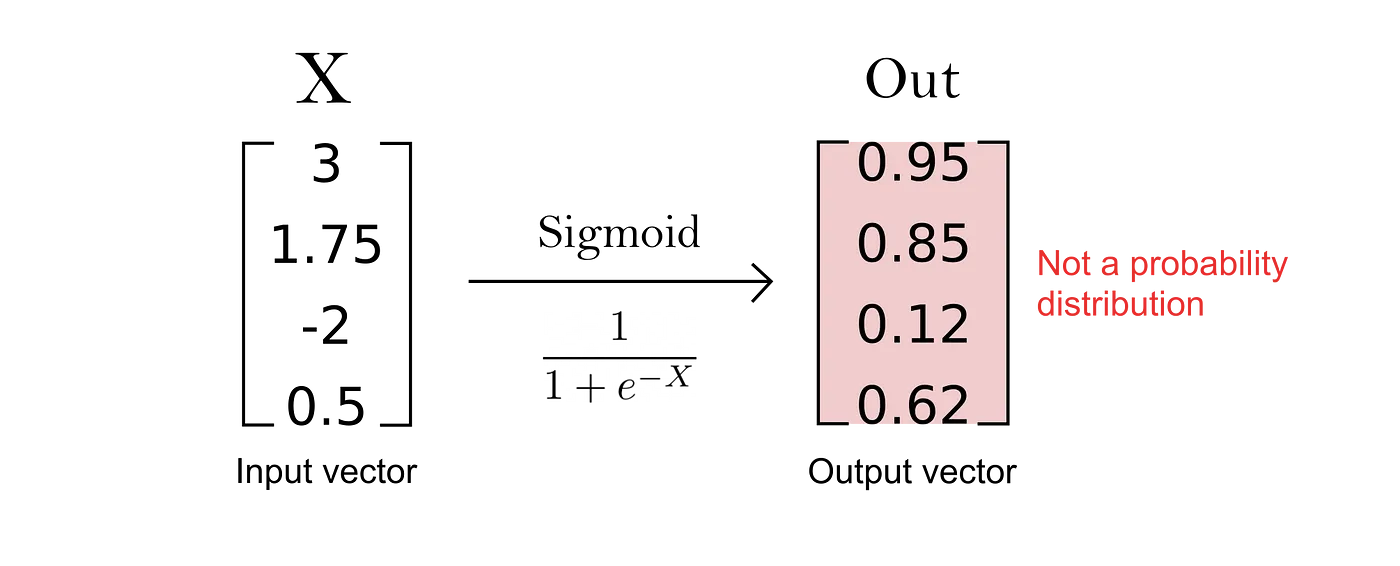


> **Sigmoid Activation**: The sigmoid function outputs values between 0 and 1 for each label independently, representing the probability of each label being present.

> Note that in validation and evaluation on test data for multilabel classification tasks, it's important to apply the sigmoid activation function instead of the softmax activation function, because applying softmax activation would assume that each instance belongs to only one label, which is not the case.

#### Datasets and Dataloaders

In [16]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze(), 'labels': torch.tensor(label)}

train_dataset = CustomDataset(X_train, Y_train, tokenizer, max_length)
valid_dataset = CustomDataset(X_val, Y_val, tokenizer, max_length)
test_dataset = CustomDataset(X_test, Y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

> Let us cross-check shapes and dimensions of Dataloader to be sure.

In [17]:
def display_info(temp_loader,name):
    first_batch_train = next(iter(temp_loader))
    input_ids_shape_train = first_batch_train['input_ids'].shape
    attention_mask_shape_train = first_batch_train['attention_mask'].shape
    labels_shape_train = first_batch_train['labels'].shape
    print(name, "Loader First Batch Shapes:")
    print("Input IDs Shape:", input_ids_shape_train)
    print("Attention Mask Shape:", attention_mask_shape_train)
    print("Labels Shape:", labels_shape_train)
    print("Number of Batches:", len(temp_loader),'\n')

display_info(train_loader,'Train')
display_info(valid_loader,'Valid')
display_info(test_loader,'Test')

Train Loader First Batch Shapes:
Input IDs Shape: torch.Size([128, 128])
Attention Mask Shape: torch.Size([128, 128])
Labels Shape: torch.Size([128, 16])
Number of Batches: 209 

Valid Loader First Batch Shapes:
Input IDs Shape: torch.Size([128, 128])
Attention Mask Shape: torch.Size([128, 128])
Labels Shape: torch.Size([128, 16])
Number of Batches: 26 

Test Loader First Batch Shapes:
Input IDs Shape: torch.Size([128, 128])
Attention Mask Shape: torch.Size([128, 128])
Labels Shape: torch.Size([128, 16])
Number of Batches: 27 



> Print some useful information about our tokenizer.

In [18]:
vocab_size = tokenizer.vocab_size
print("Vocabulary size:", vocab_size)

max_tokens = tokenizer.max_model_input_sizes[model_name]
print("Maximum number of tokens:", max_tokens)

Vocabulary size: 30522
Maximum number of tokens: 512


> Inspect what is the structure of each sample in Dataloader with a bunch of examples.

In [19]:
# Iterate over batches in train_loader
for batch_idx, batch in enumerate(train_loader):
    # Get inputs and labels from batch
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Print 3 samples
    print(f"Batch {batch_idx + 1}:")
    for i in range(min(3, len(input_ids))):
        print(f"Sample {i + 1}:")
        print("Input IDs:", input_ids[i])
        print("Attention Mask:", attention_mask[i])
        print("Labels:", labels[i])
        print()
        print()
    break

Batch 1:
Sample 1:
Input IDs: tensor([  101, 21025,  2102, 13590, 12176,  1011,  2039, 22409, 21025,  2102,
        13590, 12176,  1011,  2039, 22409, 21025,  2102, 13590, 12176,  1011,
         2039, 22409,  4007,  2797, 21025,  2102, 22409,  4354,  8241,  4866,
         2381,  2028,  2391,  2051,  4007, 21345, 21025,  2102, 22409,  2302,
         2381,  4550, 22409,  2204,  4436,  2391,  2195,  4139, 11186,  2052,
         2066, 13590, 21025,  2102, 22409,  2036,  2214,  2797, 22409,  4139,
         7928,  2130,  4431, 21025,  2102, 22409,  2052,  8235,  2797, 22409,
         2904,  2144,  2039, 11066, 10975, 13590,  4550,  2135,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0

> Each Sample contains exactly 3 Torch Tensors:
* **Input IDs** with size max_length=128, shows the indices that represent each token in the tokenizer's vocabulary.
* **Attention Mask** with size max_length=128, instructs the model which elements in the input sequence should be attended to and which should be ignored.
* **Labels** with size of Unique Tags, each label is represented as a binary value indicating the presence (1) or absence (0) of that label.



In [20]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

> Understand model's architecture and final trainable classification layer.

#### Training

In [21]:
training_init = time.time()

########################
#### Training Stage ####
########################
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', total=len(train_loader), unit='batch')
    epoch_init = time.time()
    epoch_train_loss = 0.0

    for batch_idx, batch in enumerate(train_iterator, 1):
        train_iterator.set_description(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}')

        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.float)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    ##########################
    #### Validation Stage ####
    ##########################
    epoch_val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            preds = torch.sigmoid(logits).cpu().numpy()
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0

            epoch_val_loss += loss.item()

    val_losses.append(epoch_val_loss / len(valid_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Epoch Duration: {int((time.time() - epoch_init) / 60)} minutes, Train Loss: {round(train_losses[-1],2)}, Val Loss: {round(val_losses[-1],2)}\n")

print("\nTraining Duration:", int((time.time()-training_init)/60), "minutes")

Epoch 1/3, Batch 209/209: 100%|██████████| 209/209 [10:34<00:00,  3.03s/batch]


Epoch 1/3, Epoch Duration: 11 minutes, Train Loss: 0.28, Val Loss: 0.17


Epoch 2/3, Batch 209/209: 100%|██████████| 209/209 [10:14<00:00,  2.94s/batch]


Epoch 2/3, Epoch Duration: 10 minutes, Train Loss: 0.13, Val Loss: 0.11


Epoch 3/3, Batch 209/209: 100%|██████████| 209/209 [10:10<00:00,  2.92s/batch]


Epoch 3/3, Epoch Duration: 10 minutes, Train Loss: 0.08, Val Loss: 0.08

Training Duration: 32 minutes


#### Learning Curve

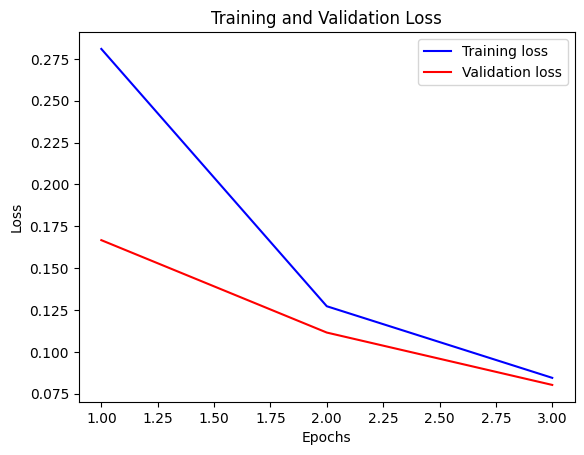

In [22]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluation

In [23]:
##########################
#### Evaluation Stage ####
##########################
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.float)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.sigmoid(logits).cpu().numpy()
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

#### Evaluation Metrics

In [24]:
# Convert predictions and labels to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute evaluation metrics
hamming_loss_val = round(hamming_loss(all_labels, all_preds),2)
micro_f1 = round(f1_score(all_labels, all_preds, average='micro'),2)
macro_f1 = round(f1_score(all_labels, all_preds, average='macro'),2)

print(f"Hamming Loss: {hamming_loss_val}\tMicro-F1: {micro_f1}\t\tMacro-F1: {macro_f1}")

Hamming Loss: 0.02	Micro-F1: 0.86		Macro-F1: 0.84


#### Classification Report for each Tag

In [25]:
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(test_df['Tag'].tolist())

> Use MultiLabelBinarizer to retrieve Tag labels.

In [26]:
print('*'*60)
for i in range(len(Y_train[0])):
    print(mlb.classes_[i])
    print(classification_report(all_labels[:,i], all_preds[:,i]),'\n'+'*'*60)

************************************************************
android
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2903
         1.0       0.98      0.91      0.94       451

    accuracy                           0.99      3354
   macro avg       0.98      0.95      0.97      3354
weighted avg       0.99      0.99      0.99      3354
 
************************************************************
angularjs
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3267
         1.0       1.00      0.93      0.96        87

    accuracy                           1.00      3354
   macro avg       1.00      0.97      0.98      3354
weighted avg       1.00      1.00      1.00      3354
 
************************************************************
c
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3257
         1.0       0.94      0.7

In [27]:
print("Total time to run the notebook:", int((time.time()-start_time)/60), "minutes")

Total time to run the notebook: 33 minutes
